In [1]:
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological, Constant
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary, meshtags
from ufl import grad, inner, split
from dolfinx import plot, default_scalar_type
from dolfinx.nls.petsc import NewtonSolver

import pyvista

In [2]:
from pathlib import Path

results_folder = Path("results/nonlinear_Naghdi/slit-annular-plate")
results_folder.mkdir(exist_ok=True, parents=True)

pyvista.start_xvfb()

# Parameter space

In [3]:
R0 = 6.0
dR = 4.0
mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, 0.0], [dR, 2*np.pi]]), [15, 120], CellType.triangle, 
                        diagonal=dolfinx.cpp.mesh.DiagonalType.right)
tdim = mesh.topology.dim
fdim = tdim - 1

## plot

In [4]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:43391/index.html?ui=P_0x7fe63594b860_0&reconnect=auto" class="pyvi…

# Initial shape

In [5]:
E, nu = Constant(mesh, default_scalar_type(21.0E6)), Constant(mesh, default_scalar_type(0.0))
mu = E/(2.0*(1.0 + nu))
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu)
t = Constant(mesh, default_scalar_type(3E-2))

In [6]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([(R0 + x[0])*ufl.cos(x[1]),
                          (R0 + x[0])*ufl.sin(x[1]),
                          0])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))


n0_ufl = unit_normal(phi0_ufl)

In [7]:
# for the 3 translation DOFs, we use the P2 + B3 enriched element
cell = mesh.basix_cell()
P2 = element("Lagrange", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

## plot 

In [8]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, element("Lagrange", cell, degree = 1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=1)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.enable_parallel_projection()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"initial_shape_rank{mesh.comm.rank}.png")
    
plotter.close()

Widget(value='<iframe src="http://localhost:43391/index.html?ui=P_0x7fe6d1388c80_0&reconnect=auto" class="pyvi…

## director

In [9]:
def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

# Shell model

element

In [10]:
P2B3 = enriched_element([P2, B3])

# for 2 rotation DOFs, we use P2 element
# mixed element for u and theta
naghdi_shell_element = mixed_element(
    [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
)
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

model

In [11]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

External work

In [12]:
def free_end(x):
    return np.isclose(x[1], 0.0)


def fixed_end(x):
    return np.isclose(x[1], 2*np.pi)

free_facets = locate_entities_boundary(mesh, fdim, free_end)
fixed_facets = locate_entities_boundary(mesh, fdim, fixed_end)

# left facets are marked with tag 1, right facets are marked with tag 2
marked_facets = np.hstack([free_facets, fixed_facets])
marked_values = np.hstack([np.full_like(free_facets, 2), np.full_like(fixed_facets, 1)])
sorted_facets = np.argsort(marked_facets)
facet_tag = meshtags(mesh, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

P_right = Constant(mesh, default_scalar_type(0.0))

ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag, metadata={"quadrature_degree": 2})

W_ext = P_right * u_func[2] * ds(2)

Potential energy with PSRI

In [13]:
# Full integration of order 4
dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Reduced integration of order 2
dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

clamped boundary condtions

In [14]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS) # default value is 0
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, facet_tag.find(1))
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS) # default value is 0
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, facet_tag.find(1))
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))

bcs = [bc_clamped_u, bc_clamped_theta]

bb tree

In [15]:
bb_tree = dolfinx.geometry.bb_tree(mesh, 2)
bb_point_A = np.array([[0.0, 0.0, 0.0]], dtype=np.float64)
bb_point_B = np.array([[dR, 0.0, 0.0]], dtype=np.float64)
# Find the leaf that the target point is in
bb_cell_candidates_A = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point_A)
bb_cell_candidates_B = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point_B)

# Find the cell from the leaf that contains the target point
bb_cells_A = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates_A, bb_point_A)
bb_cells_B = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates_B, bb_point_B)

newton solver

In [16]:
problem = NonlinearProblem(Residual, q_func, bcs, Jacobian)
solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 30
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [17]:
P_max = 0.8
nstep = 100
Ps = np.linspace(0.0, P_max, nstep)

if mesh.comm.rank == 0:
    WA_list = np.zeros(nstep)
    WB_list = np.zeros(nstep)
    
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u_naghdi.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta_naghdi.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi_naghdi.pvd", "w")
 
q_func.x.array[:] = 0.0

#dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
#dolfinx.log.set_log_level(dolfinx.log.LogLevel.OFF)

for i, P_curr in enumerate(Ps):
    P_right.value = P_curr
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {P_curr / P_max:.2f}", flush=True)
    
    # write output
    u_P2B3 = q_func.sub(0).collapse()
    theta_P2 = q_func.sub(1).collapse()

    phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
    phi_expr = Expression(phi0_ufl + u_P2B3, phi_FS.element.interpolation_points())
    phi_func = Function(phi_FS)
    phi_func.interpolate(phi_expr)

    u_P2 = Function(phi_FS)
    u_P2.interpolate(u_P2B3)

    file_u.write_function(u_P2, i)
    
    file_theta.write_function(theta_P2, i)
    
    file_phi.write_function(phi_func, i)
    
    # calculate u3 at the point load
    WA_bb = None
    WB_bb = None
    u3_func = q_func.sub(0).sub(2).collapse()
    
    if len(bb_cells_A.array) > 0:
        WA_bb = u3_func.eval(bb_point_A, bb_cells_A.array[0])[0]
    WA_bb = mesh.comm.gather(WA_bb, root=0)
    
    if len(bb_cells_B.array) > 0:
        WB_bb = u3_func.eval(bb_point_B, bb_cells_B.array[0])[0]
    WB_bb = mesh.comm.gather(WB_bb, root=0)
    
    if mesh.comm.rank == 0:
        for WA in WA_bb:
            if WA is not None:
                WA_list[i] = WA
                break
            
        for WB in WB_bb:
            if WB is not None:
                WB_list[i] = WB
                break

# close the output files
file_u.close()
file_theta.close()
file_phi.close()

Load step 0, Number of iterations: 2, Load: 0.00
Load step 1, Number of iterations: 10, Load: 0.01
Load step 2, Number of iterations: 9, Load: 0.02
Load step 3, Number of iterations: 9, Load: 0.03
Load step 4, Number of iterations: 9, Load: 0.04
Load step 5, Number of iterations: 9, Load: 0.05
Load step 6, Number of iterations: 9, Load: 0.06
Load step 7, Number of iterations: 9, Load: 0.07
Load step 8, Number of iterations: 8, Load: 0.08
Load step 9, Number of iterations: 8, Load: 0.09
Load step 10, Number of iterations: 8, Load: 0.10
Load step 11, Number of iterations: 8, Load: 0.11
Load step 12, Number of iterations: 8, Load: 0.12
Load step 13, Number of iterations: 8, Load: 0.13
Load step 14, Number of iterations: 8, Load: 0.14
Load step 15, Number of iterations: 8, Load: 0.15
Load step 16, Number of iterations: 7, Load: 0.16
Load step 17, Number of iterations: 7, Load: 0.17
Load step 18, Number of iterations: 7, Load: 0.18
Load step 19, Number of iterations: 7, Load: 0.19
Load step

## plot

In [18]:
u_P2B3 = q_func.sub(0).collapse()

phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
phi_expr = Expression(phi0_ufl + u_P2B3, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)

topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

Widget(value='<iframe src="http://localhost:43391/index.html?ui=P_0x7fe628233770_0&reconnect=auto" class="pyvi…

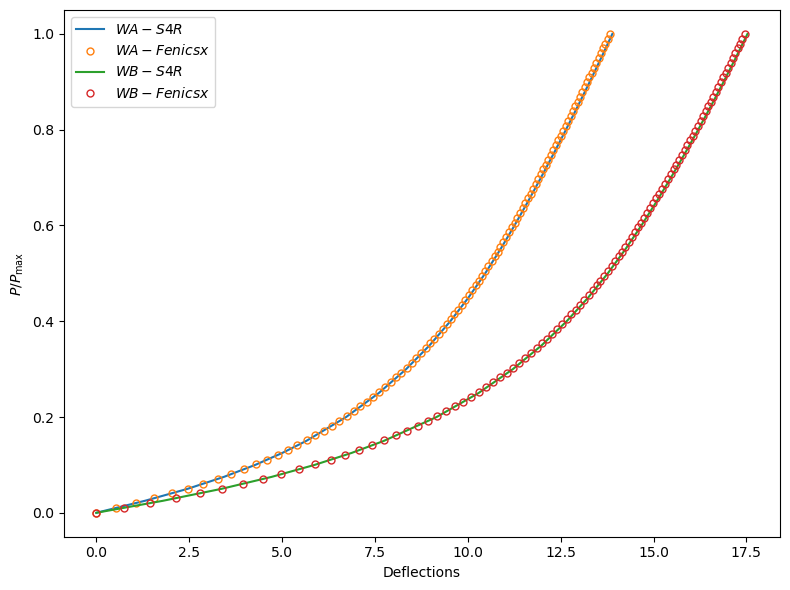

In [20]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    P_S4R = np.array([0.00, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 
                      0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                      0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
                      0.90, 0.95, 1.00])
    
    WA_S4R = np.array([0.00, 1.305, 2.455, 3.435, 4.277, 5.007, 5.649, 6.725, 7.602,
                       8.340, 8.974, 9.529, 10.023, 10.468, 10.876, 11.257, 11.620,
                       11.970, 12.310, 12.642, 12.966, 13.282, 13.590, 13.891])
    
    WB_S4R = np.array([0.00, 1.789, 3.370, 4.720, 5.876, 6.872, 7.736, 9.160, 10.288,
                       11.213, 11.992, 12.661, 13.247, 13.768, 14.240, 14.674, 15.081,
                       15.469, 15.842, 16.202, 16.550, 16.886, 17.212, 17.528])
    
    fig = plt.figure(figsize=(8.0, 6.0))
    plt.plot(WA_S4R, P_S4R, "-", label="$WA-S4R$")
    plt.plot(WA_list, Ps/P_max, "o", markersize=5, markerfacecolor='none', markevery = 1, label="$WA-Fenicsx$")
    plt.plot(WB_S4R, P_S4R, "-", label="$WB-S4R$")
    plt.plot(WB_list, Ps/P_max, "o", markersize=5, markerfacecolor='none', markevery = 1, label="$WB-Fenicsx$")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.xlabel("Deflections")
    plt.legend()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png")